In [1]:
import numpy as np
import pandas as pd

import os

In [2]:
!git clone https://github.com/Rohan-J123/GAN_Monet_DataSet

fatal: destination path 'GAN_Monet_DataSet' already exists and is not an empty directory.


In [3]:
!pip install tensorflow_addons
!pip install tensorflow==2.15.0

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

import matplotlib.pyplot as plt
import numpy as np
import re

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError as e:
    print("Error: ", e)
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
AUTO = tf.data.experimental.AUTOTUNE

print(tf.__version__)

Error:  Please provide a TPU Name to connect to.
Number of replicas: 1
2.15.0


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [4]:
with strategy.scope():
    def DiffAugment(x, policy='', channels_first=False):
        if policy:
            if channels_first:
                x = tf.transpose(x, [0, 2, 3, 1])
            for p in policy.split(','):
                for f in AUGMENT_FNS[p]:
                    x = f(x)
            if channels_first:
                x = tf.transpose(x, [0, 3, 1, 2])
        return x


    def rand_brightness(x):
        magnitude = tf.random.uniform([tf.shape(x)[0], 1, 1, 1]) - 0.5
        x = x + magnitude
        return x


    def rand_saturation(x):
        magnitude = tf.random.uniform([tf.shape(x)[0], 1, 1, 1]) * 2
        x_mean = tf.reduce_sum(x, axis=3, keepdims=True) * 0.3333333333333333333
        x = (x - x_mean) * magnitude + x_mean
        return x


    def rand_contrast(x):
        magnitude = tf.random.uniform([tf.shape(x)[0], 1, 1, 1]) + 0.5
        x_mean = tf.reduce_sum(x, axis=[1, 2, 3], keepdims=True) * 5.086e-6
        x = (x - x_mean) * magnitude + x_mean
        return x

    def rand_translation(x, ratio=0.125):
        batch_size = tf.shape(x)[0]
        image_size = tf.shape(x)[1:3]
        shift = tf.cast(tf.cast(image_size, tf.float32) * ratio + 0.5, tf.int32)
        translation_x = tf.random.uniform([batch_size, 1], -shift[0], shift[0] + 1, dtype=tf.int32)
        translation_y = tf.random.uniform([batch_size, 1], -shift[1], shift[1] + 1, dtype=tf.int32)
        grid_x = tf.clip_by_value(tf.expand_dims(tf.range(image_size[0], dtype=tf.int32), 0) + translation_x + 1, 0, image_size[0] + 1)
        grid_y = tf.clip_by_value(tf.expand_dims(tf.range(image_size[1], dtype=tf.int32), 0) + translation_y + 1, 0, image_size[1] + 1)
        x = tf.gather_nd(tf.pad(x, [[0, 0], [1, 1], [0, 0], [0, 0]]), tf.expand_dims(grid_x, -1), batch_dims=1)
        x = tf.transpose(tf.gather_nd(tf.pad(tf.transpose(x, [0, 2, 1, 3]), [[0, 0], [1, 1], [0, 0], [0, 0]]), tf.expand_dims(grid_y, -1), batch_dims=1), [0, 2, 1, 3])
        return x


    def rand_cutout(x, ratio=0.5):
        batch_size = tf.shape(x)[0]
        image_size = tf.shape(x)[1:3]
        cutout_size = tf.cast(tf.cast(image_size, tf.float32) * ratio + 0.5, tf.int32)
        offset_x = tf.random.uniform([tf.shape(x)[0], 1, 1], maxval=image_size[0] + (1 - cutout_size[0] % 2), dtype=tf.int32)
        offset_y = tf.random.uniform([tf.shape(x)[0], 1, 1], maxval=image_size[1] + (1 - cutout_size[1] % 2), dtype=tf.int32)
        grid_batch, grid_x, grid_y = tf.meshgrid(tf.range(batch_size, dtype=tf.int32), tf.range(cutout_size[0], dtype=tf.int32), tf.range(cutout_size[1], dtype=tf.int32), indexing='ij')
        cutout_grid = tf.stack([grid_batch, grid_x + offset_x - cutout_size[0] // 2, grid_y + offset_y - cutout_size[1] // 2], axis=-1)
        mask_shape = tf.stack([batch_size, image_size[0], image_size[1]])
        cutout_grid = tf.maximum(cutout_grid, 0)
        cutout_grid = tf.minimum(cutout_grid, tf.reshape(mask_shape - 1, [1, 1, 1, 3]))
        mask = tf.maximum(1 - tf.scatter_nd(cutout_grid, tf.ones([batch_size, cutout_size[0], cutout_size[1]], dtype=tf.float32), mask_shape), 0)
        x = x * tf.expand_dims(mask, axis=3)
        return x


    AUGMENT_FNS = {
        'color': [rand_brightness, rand_saturation, rand_contrast],
        'translation': [rand_translation],
        'cutout': [rand_cutout],
}
    def aug_fn(image):
        return DiffAugment(image,"color,translation,cutout")

In [5]:
def data_augment_color(image):
    image = tf.image.random_flip_left_right(image)
    image = DiffAugment(image,"color")
    return image

def data_augment_flip(image):
    image = tf.image.random_flip_left_right(image)
    return image

In [6]:
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [7]:
MONET_PATH = '/content/GAN_Monet_DataSet/monet_tfrec'
PHOTO_PATH = '/content/GAN_Monet_DataSet/photo_tfrec'

MONET_FILENAMES = tf.io.gfile.glob(str(MONET_PATH + '/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(PHOTO_PATH + '/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

n_monet_samples = count_data_items(MONET_FILENAMES)
n_photo_samples = count_data_items(PHOTO_FILENAMES)

Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [31]:
HEIGHT = 256
WIDTH = 256
CHANNELS = 3
OUTPUT_CHANNELS = 3
EPOCHS = 4
BATCH_SIZE = 8

In [9]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=CHANNELS)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [HEIGHT, WIDTH, CHANNELS])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [10]:
def load_dataset(filenames, labeled=True, ordered=False):
    # Load the dataset and map the transformation function
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

def get_gan_dataset(monet_files, photo_files, augment=None, repeat=True, shuffle=True, batch_size=1):
    monet_ds = load_dataset(monet_files)
    photo_ds = load_dataset(photo_files)

    # Apply repeat only if required
    if repeat:
        monet_ds = monet_ds.repeat()
        photo_ds = photo_ds.repeat()

    # Use a smaller shuffle buffer to save memory (tailor to your Colab RAM size)
    shuffle_buffer_size = 2048  # Start small, adjust based on available memory
    if repeat:
        monet_ds = monet_ds.repeat()
        photo_ds = photo_ds.repeat()
    if shuffle:
        monet_ds = monet_ds.shuffle(shuffle_buffer_size)
        photo_ds = photo_ds.shuffle(shuffle_buffer_size)

    # Batch the datasets
    monet_ds = monet_ds.batch(batch_size, drop_remainder=True)
    photo_ds = photo_ds.batch(batch_size, drop_remainder=True)

    if augment:
        monet_ds = monet_ds.map(augment, num_parallel_calls=AUTO)
        photo_ds = photo_ds.map(augment, num_parallel_calls=AUTO)

    # Prefetching for better performance without overloading memory
    monet_ds = monet_ds.prefetch(tf.data.experimental.AUTOTUNE)
    photo_ds = photo_ds.prefetch(tf.data.experimental.AUTOTUNE)

    # Combine the two datasets into one dataset for GAN training
    gan_ds = tf.data.Dataset.zip((monet_ds, photo_ds))

    return gan_ds

def get_photo_dataset(photo_files, augment=None, repeat=False, shuffle=False, batch_size=1):
    photo_ds = load_dataset(photo_files)
    if repeat:
        photo_ds = photo_ds.repeat()
    if shuffle:
        photo_ds = photo_ds.shuffle(2048)
    photo_ds = photo_ds.batch(batch_size, drop_remainder=True)
    if augment:
        photo_ds = photo_ds.map(augment, num_parallel_calls=AUTO)

    photo_ds = photo_ds.prefetch(tf.data.experimental.AUTOTUNE)
    return photo_ds

In [11]:
full_dataset = get_gan_dataset(MONET_FILENAMES, PHOTO_FILENAMES, augment=data_augment_flip, repeat=True, shuffle=False, batch_size=BATCH_SIZE)

In [12]:
example_monet , example_photo = next(iter(full_dataset))

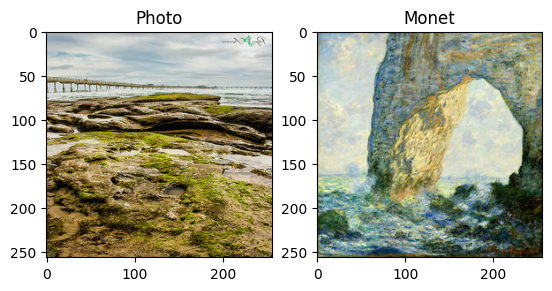

In [13]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

In [14]:
def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

In [15]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

In [16]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

In [17]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

In [18]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

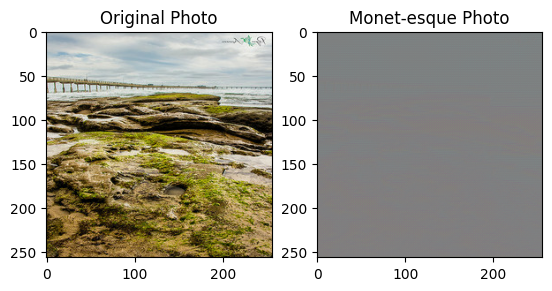

In [19]:
to_monet = monet_generator(example_photo)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

In [20]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle

    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        batch_size = tf.shape(real_monet)[0]
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            ################## My code #####################

            both_monet = tf.concat([real_monet, fake_monet], axis=0)

            aug_monet = aug_fn(both_monet)

            aug_real_monet = aug_monet[:batch_size]
            aug_fake_monet = aug_monet[batch_size:]

            ################ End of my code #################

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(aug_real_monet, training=True) # aug_real_monet
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(aug_fake_monet, training=True) # aug_fake_monet
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))

        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

In [21]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

In [22]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True,
                                                  reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [23]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [24]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_sum(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss * 0.0000152587890625

In [25]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [26]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [ ]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

tf.data.Dataset.zip((monet_ds, photo_ds))

cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=50
)

Epoch 1/4
879/879 [==============================] - 1169s 1s/step - monet_gen_loss: 12.5938 - photo_gen_loss: 15.4512 - monet_disc_loss: 0.5558 - photo_disc_loss: 0.3965
Epoch 2/4
879/879 [==============================] - 1168s 1s/step - monet_gen_loss: 7.3638 - photo_gen_loss: 10.4614 - monet_disc_loss: 0.5643 - photo_disc_loss: 0.4324
Epoch 3/4
879/879 [==============================] - 1166s 1s/step - monet_gen_loss: 6.0061 - photo_gen_loss: 8.6298 - monet_disc_loss: 0.5704 - photo_disc_loss: 0.4366
Epoch 4/4
879/879 [==============================] - 1166s 1s/step - monet_gen_loss: 5.4833 - photo_gen_loss: 7.8919 - monet_disc_loss: 0.5939 - photo_disc_loss: 0.4452


In [33]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [ ]:
tf.data.Dataset.zip((monet_ds, photo_ds))

cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=50
)

Epoch 1/2
219/219 [==============================] - 291s 1s/step - monet_gen_loss: 5.2705 - photo_gen_loss: 7.4005 - monet_disc_loss: 0.5699 - photo_disc_loss: 0.4280
Epoch 2/2
219/219 [==============================] - 290s 1s/step - monet_gen_loss: 5.2316 - photo_gen_loss: 7.3644 - monet_disc_loss: 0.5847 - photo_disc_loss: 0.4432


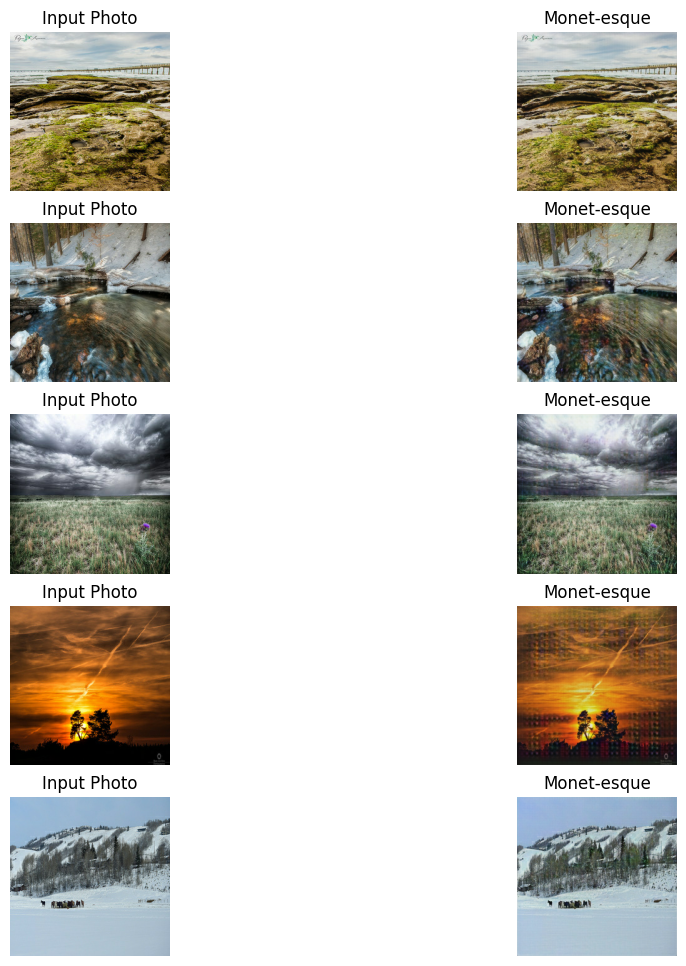

In [ ]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

In [39]:
import PIL
def predict_and_save(input_ds, generator_model, output_path):
    i = 1
    for img in input_ds:
        prediction = generator_model(img, training=False)[0].numpy() # make predition
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)   # re-scale
        im = PIL.Image.fromarray(prediction)
        im.save(f'{output_path}{str(i)}.jpg')
        i += 1

In [40]:
import os
os.makedirs('../images/')

predict_and_save(load_dataset(PHOTO_FILENAMES).batch(1), monet_generator, '../images/')

In [41]:
!zip -r /content/generated_jpg_4.zip ../images

Streaming output truncated to the last 5000 lines.
  adding: ../images/5930.jpg (deflated 1%)
  adding: ../images/1743.jpg (deflated 1%)
  adding: ../images/3533.jpg (deflated 1%)
  adding: ../images/6420.jpg (deflated 4%)
  adding: ../images/3254.jpg (deflated 1%)
  adding: ../images/6250.jpg (deflated 1%)
  adding: ../images/659.jpg (deflated 1%)
  adding: ../images/747.jpg (deflated 1%)
  adding: ../images/1524.jpg (deflated 1%)
  adding: ../images/851.jpg (deflated 1%)
  adding: ../images/5325.jpg (deflated 2%)
  adding: ../images/1729.jpg (deflated 1%)
  adding: ../images/4276.jpg (deflated 2%)
  adding: ../images/1983.jpg (deflated 2%)
  adding: ../images/5703.jpg (deflated 2%)
  adding: ../images/4826.jpg (deflated 1%)
  adding: ../images/4989.jpg (deflated 1%)
  adding: ../images/2201.jpg (deflated 1%)
  adding: ../images/1935.jpg (deflated 2%)
  adding: ../images/4660.jpg (deflated 6%)
  adding: ../images/984.jpg (deflated 1%)
  adding: ../images/4396.jpg (deflated 1%)
  addin

In [45]:
from google.colab import files
files.download("/content/generated_jpg_4.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>